In [1]:
!pip install opencv-python numpy keras tensorflow matplotlib scipy

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import glob

# Check for GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    print(f"✅ GPU detected: {gpus[0].name}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("❌ No GPU detected. Running on CPU.")

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 8
EPOCHS = 11
LEARNING_RATE = 0.001
DATASET_PATH = 'dataset'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU detected: /physical_device:GPU:0


In [3]:
# Function to preprocess images
def preprocess_image(image_path):
    # Read image
    img = cv2.imread(image_path)
    
    # Resize to 128x128
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)
    
    # Back to BGR (3 channels)
    bgr_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    
    # Normalize pixel values to [0, 1]
    normalized_img = bgr_img / 255.0
    
    return normalized_img

In [4]:
# Function to load and preprocess the dataset
def load_dataset(dataset_path):
    images = []
    labels = []
    
    # Get all angle folders
    angle_folders = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
    
    # Create a mapping of folder names to integer labels
    class_indices = {folder: i for i, folder in enumerate(angle_folders)}
    
    for angle_folder in angle_folders:
        angle_path = os.path.join(dataset_path, angle_folder)
        image_files = glob.glob(os.path.join(angle_path, '*.*'))
        
        for image_file in image_files:
            # Preprocess the image
            img = preprocess_image(image_file)
            images.append(img)
            
            # Get the label from the folder name
            labels.append(class_indices[angle_folder])
    
    return np.array(images), np.array(labels), class_indices

In [5]:
# Load and preprocess the dataset
X, y, class_indices = load_dataset(DATASET_PATH)
print(f"Loaded {len(X)} images with {len(class_indices)} different angle classes")
print(f"Classes: {class_indices}")

# Convert labels to one-hot encoding
y_one_hot = tf.keras.utils.to_categorical(y, num_classes=len(class_indices))

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y)

Loaded 2657 images with 15 different angle classes
Classes: {'000': 0, '025': 1, '050': 2, '075': 3, '100': 4, '125': 5, '150': 6, '175': 7, '200': 8, '225': 9, '250': 10, '275': 11, '300': 12, '325': 13, '350': 14}


In [6]:
# Create a data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

In [7]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_indices), activation='softmax')
])


In [8]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.00001
)

checkpoint = ModelCheckpoint(
    'text_angle_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, checkpoint]
)


Epoch 1/11
266/266 [==============================] - 12s 28ms/step - loss: 2.7213 - accuracy: 0.0635 - val_loss: 2.7074 - val_accuracy: 0.0846 - lr: 0.0010
Epoch 2/11
266/266 [==============================] - 6s 24ms/step - loss: 2.4857 - accuracy: 0.1689 - val_loss: 1.2446 - val_accuracy: 0.6786 - lr: 0.0010
Epoch 3/11
266/266 [==============================] - 7s 26ms/step - loss: 1.3170 - accuracy: 0.5261 - val_loss: 0.4889 - val_accuracy: 0.8402 - lr: 0.0010
Epoch 4/11
266/266 [==============================] - 7s 28ms/step - loss: 0.8596 - accuracy: 0.6800 - val_loss: 0.3371 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 5/11
266/266 [==============================] - 7s 26ms/step - loss: 0.6898 - accuracy: 0.7586 - val_loss: 0.2599 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 6/11
266/266 [==============================] - 7s 26ms/step - loss: 0.5405 - accuracy: 0.7934 - val_loss: 0.1647 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 7/11
266/266 [==============================] - 7s 25ms/s

In [19]:
print(f"Validation Accuracy: {max(history.history['val_accuracy']) * 100:.2f}%")
print(f"Accuracy: {max(history.history['accuracy']) * 100:.2f}%")

Validation Accuracy: 97.74%
Accuracy: 88.66%


In [12]:
# Save the final model
model.save('angle_detector_model.h5')

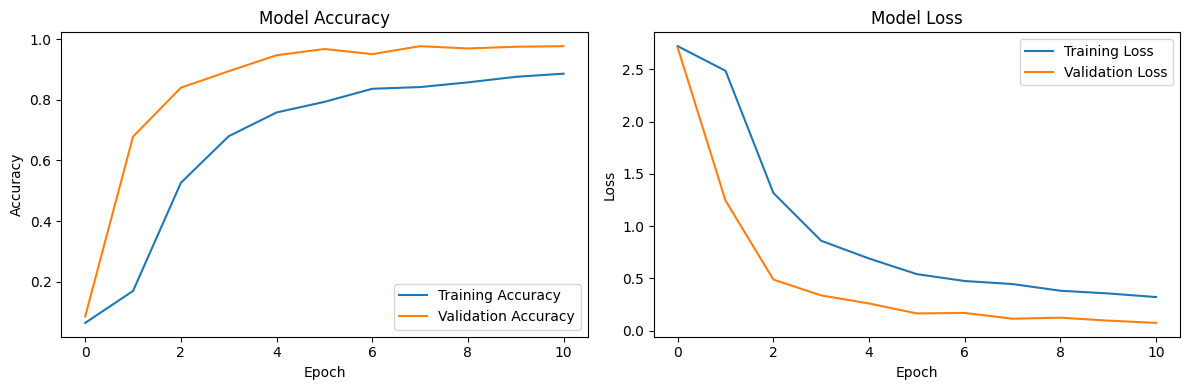

In [13]:
# Plot training results
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Print final learning rate
final_lr = tf.keras.backend.get_value(model.optimizer.lr)

print(f"Final learning rate: {tf.keras.backend.get_value(model.optimizer.lr)} / {final_lr:.1e}")


Final learning rate: 0.0010000000474974513 / 1.0e-03


In [15]:
# Function to predict the angle from an image
def predict_angle(image_path, model, class_indices):
    # Preprocess the image
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img)[0]
    predicted_class = np.argmax(prediction)
    
    # Get the angle from the class index
    reverse_class_mapping = {v: k for k, v in class_indices.items()}
    predicted_angle = reverse_class_mapping[predicted_class]
    
    return predicted_angle, prediction[predicted_class]

In [1]:
test_image_path = 'C:/Users/drflo/Desktop/111.jpg'
predicted_angle, confidence = predict_angle(test_image_path, model, class_indices)
print(f"Predicted angle: {predicted_angle} with confidence: {confidence:.2f}")

NameError: name 'predict_angle' is not defined